In [83]:
import numpy as np
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [84]:
def tensor(A, B):
    m = len(A)*len(B)
    n = len(A[0])*len(B[0])

    prod = []

    for i in range(m):
        prod.append([])
        for j in range(n):
            ax = int(i / len(B))
            ay = int(j / len(B[0]))
            bx = int(i % len(B))
            by = int(j % len(B[0]))
            prod[i].append(A[ax][ay]*B[bx][by])

    return np.array(prod)

def tensor_list(ops):
    prod = ops[-1]
    for i in range(len(ops)-2, -1, -1):
        prod = tensor(ops[i], prod)
    return np.array(prod)

def pauli(pos, dir, N):
    factors = [[[1, 0], [0, 1]]]*N
    if dir == 'x':
        factors[pos] = [[0, 1], [1, 0]]
    elif dir == 'y':
        factors[pos] = [[0, -1j], [1j, 0]]
    elif dir == 'z':
        factors[pos] = [[1, 0], [0, -1]]

    return tensor_list(factors)

def on_site_detuning(pos, N):
    sum = 0
    for j in range(N):
        if np.abs(pos - j) == 1:
            sum += V_nn
        elif np.abs(pos - j) == 2:
            sum += V_nnn

    return -0.5 * sum

def interaction_strength(pos1, pos2):
    if np.abs(pos1 - pos2) == 1:
        return V_nn
    if np.abs(pos1 - pos2) == 2:
        return V_nnn
    else:
        return 0

In [85]:
def gram_schmidt(v, basis):
    proj = sum([np.dot(v, b) * b for b in basis])
    w = v - proj
    # if v \in span(basis), we have reached dimension of Krylov subspace
    if np.linalg.norm(w) <= 0.001:
        return []
    return w / np.linalg.norm(w)

def krylovbasis(H, psi0, dim):
    kbasis = np.transpose(psi0)/np.linalg.norm(psi0)
    for i in range(dim-1):
        next_v = np.dot(H, kbasis[-1])
        next_v = gram_schmidt(next_v, kbasis) # orthonormalize
        if len(next_v) == 0:
            break
        kbasis = np.append(kbasis, [next_v], axis=0)

    return kbasis

def diag_power(S, n):
    for i in range(len(S)):
        S[i][i] = S[i][i]**n
    return S

# custom implementation runs into issues with numerical stability that scipy solves
# scipy uses Pade approximation, this is just an eigendecomp
def mat_exp(S):
    eigenvalues, U_inv = np.linalg.eig(S)
    U = np.linalg.inv(U_inv)
    D = np.diag([np.exp(eig) for eig in eigenvalues])
    return U @ D @ U_inv

def expectation(op, psi):
    return np.dot(np.conj(psi), np.dot(op, psi))

def krylovsolve(H, psi0, tlist, krylov_dim, e_ops=[]):
    psi = np.transpose(psi0)[0]
    probs = np.array([np.dot(psi, [0, 1/np.sqrt(2), 1/np.sqrt(2), 0])])
    expect = [[expectation(op, psi)] for op in e_ops]

    V = np.conj(krylovbasis(H, psi0, krylov_dim))
    # print(V)
    V_dag = np.conj(np.transpose(V))
    T = V @ H @ V_dag

    # expme = U @ sum([((complex(0, -trotter)**j)/math.factorial(j)) * diag_power(D, j) for j in range(40)]) @ U_inv

    for i in range(len(tlist)-1):
        time_ev = V_dag @ expm(complex(0, -tlist[i])*T) @ V
        
        # time_ev = V_dag @ mat_exp(complex(0, -tlist[i]) * T) @ V
        psi_new = np.dot(time_ev, psi)

        probs = np.append(probs, [np.abs(np.dot(psi_new, [0, 1/np.sqrt(2), 1/np.sqrt(2), 0]))**2], axis=0)

        for o in range(len(e_ops)):
            expect[o] = np.append(expect[o], [expectation(e_ops[o], psi_new)], axis=0)
    return [expect, probs]

In [86]:
N = 2
psi0 = tensor_list([[[0], [1]]] * N)
tlist = np.linspace(0.0, 4, 200)

max_F = []

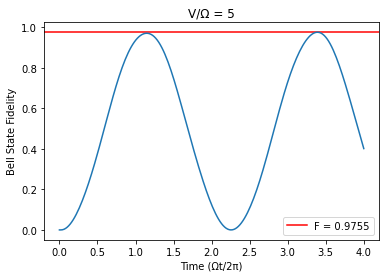

In [87]:
strength = 5
ham = np.array([[2*strength, 1, 1, 0], [1, 0, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]])
probs = krylovsolve(ham, psi0, tlist, krylov_dim=min(2**N, 40))[1]
max_F.append(round(max(probs), 4))

plt.figure()
plt.title("V/Ω = 5")
plt.axhline(y=max(probs), color='r', linestyle='-', label="F = " + str(round(max(probs), 4)))
plt.plot(tlist, probs)
plt.xlabel('Time (Ωt/2π)')
plt.ylabel('Bell State Fidelity')
plt.legend()
plt.show()

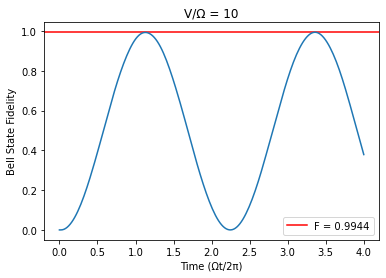

In [88]:
strength = 10
ham = np.array([[2*strength, 1, 1, 0], [1, 0, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]])
probs = krylovsolve(ham, psi0, tlist, krylov_dim=min(2**N, 40))[1]
max_F.append(round(max(probs), 4))

plt.figure()
plt.title("V/Ω = 10")
plt.axhline(y=max(probs), color='r', linestyle='-', label="F = " + str(round(max(probs), 4)))
plt.plot(tlist, probs)
plt.xlabel('Time (Ωt/2π)')
plt.ylabel('Bell State Fidelity')
plt.legend()
plt.show()

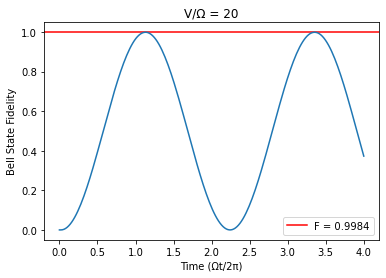

In [89]:
strength = 20
ham = np.array([[2*strength, 1, 1, 0], [1, 0, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]])
probs = krylovsolve(ham, psi0, tlist, krylov_dim=min(2**N, 40))[1]
max_F.append(round(max(probs), 4))

plt.figure()
plt.title("V/Ω = 20")
plt.axhline(y=max(probs), color='r', linestyle='-', label="F = " + str(round(max(probs), 4)))
plt.plot(tlist, probs)
plt.xlabel('Time (Ωt/2π)')
plt.ylabel('Bell State Fidelity')
plt.legend()
plt.show()

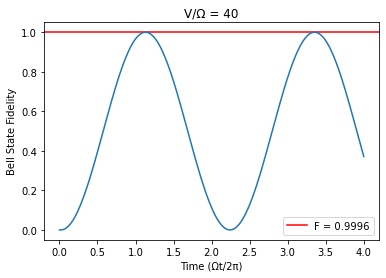

In [90]:
strength = 40
ham = np.array([[2*strength, 1, 1, 0], [1, 0, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]])
probs = krylovsolve(ham, psi0, tlist, krylov_dim=min(2**N, 40))[1]
max_F.append(round(max(probs), 4))

plt.figure()
plt.title("V/Ω = 40")
plt.axhline(y=max(probs), color='r', linestyle='-', label="F = " + str(round(max(probs), 4)))
plt.plot(tlist, probs)
plt.xlabel('Time (Ωt/2π)')
plt.ylabel('Bell State Fidelity')
plt.legend()
plt.show()

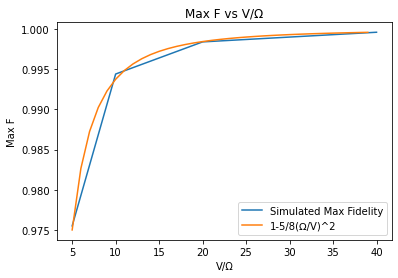

In [91]:
plt.figure()
plt.title("Max F vs V/Ω")
plt.plot([5, 10, 20, 40], max_F, label="Simulated Max Fidelity")
x = np.array(range(5, 40), dtype=float)
y = 1 - 5/8 * np.power(x, -2)
plt.plot(x, y, label="1-5/8(Ω/V)^2")
plt.xlabel('V/Ω')
plt.ylabel('Max F')
plt.legend()
plt.show()

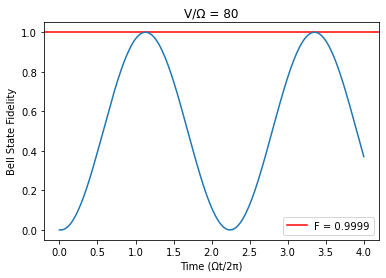

In [93]:
strength = 80
ham = np.array([[2*strength, 1, 1, 0], [1, 0, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]])
probs = krylovsolve(ham, psi0, tlist, krylov_dim=min(2**N, 40))[1]

plt.figure()
plt.title("V/Ω = 80")
plt.axhline(y=max(probs), color='r', linestyle='-', label="F = " + str(round(max(probs), 4)))
plt.plot(tlist, probs)
plt.xlabel('Time (Ωt/2π)')
plt.ylabel('Bell State Fidelity')
plt.legend()
plt.show()